# MINBAR Python tutorial

This notebook contains example code for accessing the Multi-INstrument Burst ARchive (MINBAR) data release 1.

For a description of MINBAR, see the paper ([Galloway et al. 2020](https://ui.adsabs.harvard.edu/abs/2020ApJS..249...32G)) or the [website](http://burst.sci.monash.edu/minbar)

The database is available in three forms:
* a set of ASCII files, available from https://doi.org/10.26180/5e4a697d9b8b6
* an online version at http://burst.sci.monash.edu (based on the IDL database)
* an IDL database (not publicly available)

This tutorial includes access options based on downloading the ASCII files and set them up as suggested in the `README.md` file in the repository, see the "Using the MINBAR class" section; but also direct access via the web portal, see "Using the online web portal"

In [13]:
from math import *
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import minbar

## Using the minbar class

The minbar class can be used to load the databases from the ASCII files or IDL database.

The two options provide _basically_ the same functionality, although the data structure is slightly different, and it affects the string formats (str for ASCII, but bytearrays for IDL). 

The ASCII files for both the bursts and observations include a subset of the events in the IDL database.

The default behaviour is `IDL=False` so it's not required to use the keywords in the examples below if you have the ASCII files.

In [2]:
# These commands load MINBAR, by default now from the ASCII files
# you can switch to IDL with (instead) the flag IDL=True

use_IDL_db = False
b = minbar.Bursts(IDL=use_IDL_db)
o = minbar.Observations(IDL=use_IDL_db)

print("Got {} bursts and {} observations from MINBAR".format(len(b),len(o)))

INFO:minbar:loading observations, please wait...


Got 7111 bursts and 118848 observations from MINBAR


Basic functionality includes selecting bursts or observations from certain sources, or with certain criteria. In the example below, we select all the PCA bursts observed from 4U 1636-536 after MJD 53465. 

In [3]:
b.name_like('1636-53') # you can use partial names here

pca = b.instr_like('XP') # select all the RXTE/PCA bursts

pca_fluence = b['fluen'][pca] # extract the fluen attribute for these bursts

late = b['time']>53465.0
late_pca_fluence = b['fluen'][pca&late]
print(late_pca_fluence)

INFO:minbar:selected 666 bursts from 4U 1636-536


 fluen  
ct / cm2
--------
  33.826
   30.79
   3.263
  42.066
   1.375
  33.799
  38.617
  43.634
  22.514
   0.354
     ...
   33.13
  19.544
   3.759
   6.235
   14.47
  36.137
  24.047
  37.654
  36.591
   8.801
Length = 259 rows


In [4]:
# Here's the same example, in one line

late_pca_fluence = b['fluen'][pca & (b['time']>53465.0)]
print (len(late_pca_fluence))

# Consider all sources again, not just 1636-53

b.clear()

259


Data is returned as numpy arrays, and we can use matplotlib to do some simple plotting (see also http://matplotlib.org/users/pyplot_tutorial.html)

INFO:minbar:selected 666 bursts from 4U 1636-536


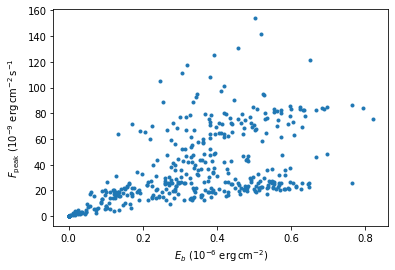

In [5]:
b.name_like('1636-53')

good = b['sflag'] == '-' # include only the bursts without data analysis flags

fluence = b['bfluen'][good]
fpeak = b['bpflux'][good]
# print fluence

plt.plot(fluence, fpeak, '.')
plt.ylabel(r'$F_{\rm peak}\ (10^{-9}\ {\rm erg\,cm^{-2}\,s^{-1}}$')
plt.xlabel(r'$E_b\ (10^{-6}\ {\rm erg\,cm^{-2}})$')
plt.show()

b.clear()

## Select a particular observation and perform some analysis

Here we select a particular observation, and generate the observation object to perform some analysis

In [6]:
# Select a particular observation and retrieve the lightcurve

o.name_like('1636')
sel = o.instr_like('pca') & (o['nburst'] > 0)
# print (o['entry'][sel][0])

obs_db_item = o[o['entry'][sel][0]] # contains the table row data corresponding to the first observation
print (obs_db_item)

INFO:minbar:selected 2978 observations from 4U 1636-536


    name    instr     obsid      entry sflag    tstart      tstop    exp  angle  vigcorr nburst   count     e_count    sig        flux         e_flux    gamma   sc    hc   s_z     model     plind e_plind plnorm e_plnorm  kT e_kT bbnorm e_bbnorm  T_0  e_T_0  kT_e e_kT_e tau  e_tau  cnorm e_cnorm line e_line sigma e_sigma  gnorm  e_gnorm  chisqr e_chisqr
                                                  d           d       s   arcmin                ct s / cm2 ct s / cm2        1e-09 mW / m2 1e-09 mW / m2                                                                    keV keV                   keV   keV   keV   keV                             keV   keV    keV    keV                                   
----------- ----- -------------- ----- ----- ----------- ----------- ---- ------ ------- ------ ---------- ---------- ------ ------------- ------------- ------ ---- ----- ----- ------------ ----- ------- ------ -------- --- ---- ------ -------- ----- ------ ---- ------ ---- ------ ----- --

In [7]:
print ("Now creating observation from entry #{}\n".format(obs_db_item['entry']))

obs_db = minbar.Observation(obs_db_item)

print (obs_db)

INFO:minbar:adopted distances for X=0.0, using Gaia/cluster distances where available


Now creating observation from entry #14637

MINBAR observation of 4U 1636-536
Instrument: PCA
ObsID: 10088-01-07-02
Time range: 50445.93334 d-50446.09376 d
Data path: /Users/Shared/burst/minbar/xte/data/4U1636-536/10088-01-07-02


In [8]:
# Can achieve the same thing by specifying the instrument, source and obsid 

xte = minbar.Instrument('PCA')
obs = minbar.Observation(None, xte, '4U 1636-536', '10088-01-07-02')

print (obs)

INFO:minbar:adopted distances for X=0.0, using Gaia/cluster distances where available


MINBAR observation of 4U 1636-536
Instrument: PCA
ObsID: 10088-01-07-02
Data path: /Users/Shared/burst/minbar/xte/data/4U1636-536/10088-01-07-02


In [9]:
print (obs.instr, obs.name, obs.obsid)
print (obs_db.instr, obs_db.name, obs_db.obsid)

# obs.instr.source_path[obs.instr.source == '4U 1636-356']
obs_db.instr.source_path[obs.instr.source_name == '4U 1636-536']



MINBAR instrument definition

Name: PCA (XP)
Data path: xte
Lightcurve(s): <bound method Instrument.pca_lightcurve_filename of <minbar.Instrument object at 0x12229f520>>
Spectra: None 4U 1636-536 10088-01-07-02

MINBAR instrument definition

Name: PCA (XP)
Data path: xte
Lightcurve(s): <bound method Instrument.pca_lightcurve_filename of <minbar.Instrument object at 0x1236031f0>>
Spectra: None 4U 1636-536 10088-01-07-02


array(['4U1636-536'], dtype='<U21')

## The MINBAR source catalog

This section shows some basic use of the MINBAR source catalog

In [10]:
s = minbar.Sources()
print ("Got {} sources from the MINBAR catalog".format(len(s)))

INFO:minbar:adopted distances for X=0.0, using Gaia/cluster distances where available


Got 115 sources from the MINBAR catalog


(-20.0, 20.0)

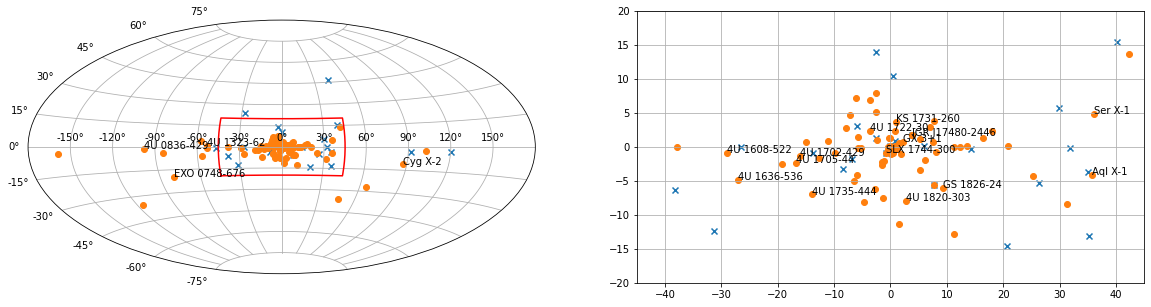

In [11]:
llim, blim = 45, 20
nburst_min_annotate = 50
url_base='https://burst.sci.monash.edu/aqoutput?dtype=bursts&fields=name%2Ctime%2Cinstr&output=html&timef=mjd&query_field_select=name&qfield=type&query_op=%3D&query_val=1&query_reln=%26&qfield=name&query_op=%3D&query_val={}'

def source_plot(gal, nburst, name=None, radian=True):
    '''
    Simple plotting routine to plot the MINBAR sources differently depending on the number of bursts
    '''
    
    has_bursts = nburst>0
    no_bursts = nburst==0
    
    if radian:
        plt.scatter(gal[no_bursts].l.wrap_at('180d').radian, gal[no_bursts].b.radian, marker='x')
        plt.scatter(gal[has_bursts].l.wrap_at('180d').radian, gal[has_bursts].b.radian)
    else:
        plt.scatter(gal[no_bursts].l.wrap_at('180d'), gal[no_bursts].b, marker='x')
        plt.scatter(gal[has_bursts].l.wrap_at('180d'), gal[has_bursts].b)

# https://docs.astropy.org/en/stable/coordinates/

from astropy import units as u
from astropy.coordinates import SkyCoord
c = SkyCoord(ra=s['ra_obj']*u.degree, dec=s['dec_obj']*u.degree, frame='icrs')

# convert to Galactic coordinates

gal = c.galactic

# and plot; example adapted from
# https://astronomy.stackexchange.com/questions/32601/how-do-i-plot-galactic-coordinates-using-matplotlib-and-astropy-in-python
#
# multiple panels from 
# https://matplotlib.org/3.1.0/gallery/subplots_axes_and_figures/subplots_demo.html

plt.figure(figsize=(20,5))

plt.subplot(121, projection='aitoff')
plt.grid(True)
# ax1.axes(projection='aitoff')
# plt.scatter(gal.l.wrap_at('180d').radian, gal.b.radian)
source_plot(gal, s['nburst'])
# show zoom box

plt.plot(np.array([-llim, -llim, llim, llim, -llim])*pi/180, 
         np.array([-blim, blim, blim, -blim, -blim])*pi/180, 'r')

# hyperlink annotations; see 
# https://stackoverflow.com/questions/15417586/python-matlplotlib-add-hyperlink-to-text

for i, txt in enumerate(s['name']):
    # print (i, txt, gal[i].l.value, gal[i].b.value, s['nburst'][i])

    # plt.annotate(s['nburst'][i], (gal[i].l.wrap_at('180d').radian, gal[i].b.radian))
    if (s['nburst'][i] > nburst_min_annotate) and ((gal[i].l.value > llim and gal[i].l.value < 360-llim) or (abs(gal[i].b.value) > blim)):
        # print (txt, s['nburst'][i], (gal[i].l.radian, gal[i].b.radian))
        # print (url_base.format(s['name'][i].replace(' ','+')))
        plt.annotate(txt, (gal[i].l.wrap_at('180d').radian, gal[i].b.radian), 
                     url=url_base.format(s['name'][i].replace(' ','+')))

plt.subplot(122)
plt.grid(True)
# plt.scatter(gal.l.wrap_at('180d'), gal.b)#, aspect=0.5)
source_plot(gal, s['nburst'], radian=False)#, aspect=0.5)

for i, txt in enumerate(s['name']):
    if ((gal[i].l.value < llim) | (gal[i].l.value > 360-llim)) & (abs(gal.b[i].value) < blim) & (abs(gal.b[i].value) > 0.75) & (s['nburst'][i] > nburst_min_annotate): 
        # print (txt, s['nburst'][i])
        plt.annotate(txt, (gal[i].l.wrap_at('180d').value, gal[i].b.value),
                    url=url_base.format(s['name'][i].replace(' ','+')))

plt.xlim(-llim, llim)
plt.ylim(-blim, blim)
#plt.set_aspect(0.5)

# plt.savefig('sources.svg')

## Using the online web portal

The portal at http://burst.sci.monash.edu can be used to select bursts and observations from the MINBAR sample, and do simple plotting. In the case that you've selected some events there and want to do some more complex analysis, you can use the URL with the ASCII output option to read the table directly into Python.

In this example we've run a search on the bursts to replicate the selection performed above, that is, all the unflagged RXTE/PCA bursts from 4U 1636-536, and then chosen the ASCII output option. The resulting URL is defined below

Note for this query we've included the `entry` field for ease of identification of the different events. This field could be adopted as the pandas table index.

In [16]:
portal_url = 'https://burst.sci.monash.edu/aqoutput?dtype=bursts&fields=entry%2Cname%2Ctime%2Cbfluen%2Cbpflux&output=topcat&timef=mjd&qfield=type&query_op=%3D&query_val=1&query_reln=%26&qfield=name&query_op=%3D&query_val=1636&query_reln=%26&qfield=sflag&query_op=%3D&query_val=-'

c=pd.read_csv(portal_url, comment='#', sep='\t', header=0, index_col=False)

c

,entry,name,time,bfluen,bfluene,bpflux,bpfluxe
0,1719,4U 1636-536,50349.93785,0.1897,0.0404,20.61,11.93
1,1720,4U 1636-536,50351.07714,0.2459,0.0439,105.44,46.58
2,1721,4U 1636-536,50361.49186,0.5290,0.0431,80.55,13.54
3,1722,4U 1636-536,50385.16030,0.3353,0.1556,88.83,41.23
4,2258,4U 1636-536,50445.99586,0.0616,0.0030,18.52,0.67
...,...,...,...,...,...,...,...
608,8624,4U 1636-536,55964.56087,0.0000,0.0000,0.00,0.00
609,8625,4U 1636-536,55967.51912,0.0000,0.0000,0.00,0.00
610,8626,4U 1636-536,55967.77350,0.0000,0.0000,0.00,0.00
611,8656,4U 1636-536,55977.00053,0.0000,0.0000,0.00,0.00


Text(0.5, 0, '$E_b\\ (10^{-6}\\ {\\rm erg\\,cm^{-2}})$')

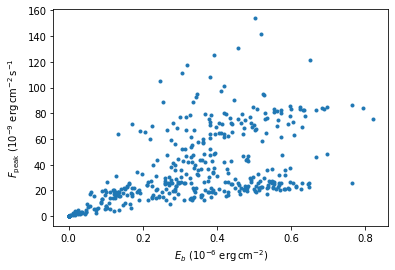

In [17]:
# Here we replicate the plot from use of the ASCII tables

plt.plot(c['bfluen'],c['bpflux'],'.')

plt.ylabel(r'$F_{\rm peak}\ (10^{-9}\ {\rm erg\,cm^{-2}\,s^{-1}}$')
plt.xlabel(r'$E_b\ (10^{-6}\ {\rm erg\,cm^{-2}})$')